In [ ]:
import torch
import numpy as np
import time
import scipy.io  # For loading .mat files
import pandas as pd
import matplotlib.pyplot as plt # For plotting data

# =============================================================================
# 1. Device Configuration
# =============================================================================
# Set the computation device to a CUDA-enabled GPU if available, otherwise default to CPU.
# This ensures the script can leverage GPU acceleration for tensor operations.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# =============================================================================
# 2. Core Operator and Function Definitions
# =============================================================================

def get_pauli_matrices() -> dict[str, torch.Tensor]:
    """
    Generates the fundamental Pauli matrices (I, X, Y, Z).

    Returns:
        dict[str, torch.Tensor]: A dictionary mapping the Pauli operator name
                                 (as a string) to its complex tensor representation.
    """
    pauli_i = torch.tensor([[1, 0], [0, 1]], dtype=torch.complex64, device=device)
    pauli_x = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex64, device=device)
    pauli_y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex64, device=device)
    pauli_z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex64, device=device)
    return {'I': pauli_i, 'X': pauli_x, 'Y': pauli_y, 'Z': pauli_z}


def create_n_body_operator(pauli_ops: list[torch.Tensor]) -> torch.Tensor:
    """
    Constructs a multi-qubit operator using the tensor product (Kronecker product)
    of single-qubit Pauli matrices.

    Args:
        pauli_ops (list[torch.Tensor]): A list of single-qubit Pauli tensors.

    Returns:
        torch.Tensor: The resulting N-body operator as a single tensor.
    """
    op = pauli_ops[0]
    for i in range(1, len(pauli_ops)):
        op = torch.kron(op, pauli_ops[i])
    return op


def calculate_C_LB(lambda_param: torch.Tensor,
                   log_rho_d: torch.Tensor,
                   identity_matrix: torch.Tensor,
                   W_matrices: torch.Tensor,
                   w: torch.Tensor) -> torch.Tensor:
    """
    Calculates the lower bound of the coherence C_l(rho), which serves as the
    loss function for the optimization problem. This is the dual problem objective.

    Args:
        lambda_param (torch.Tensor): The vector of Lagrange multipliers (optimization variables).
        log_rho_d (torch.Tensor): The matrix logarithm of the diagonal input state rho_d.
        identity_matrix (torch.Tensor): An identity matrix of the appropriate dimension.
        W_matrices (torch.Tensor): A stack of constraint operator matrices.
        w (torch.Tensor): The vector of expectation values for the constraints.

    Returns:
        torch.Tensor: A scalar tensor representing the loss value.
    """
    # L_star_lambda is the adjoint operator applied to lambda.
    L_star_lambda = torch.einsum('i,ijk->jk', lambda_param.to(torch.complex64), W_matrices)
    
    # The exponent of the matrix exponential term in the dual problem.
    exponent_matrix = log_rho_d - identity_matrix - L_star_lambda
    
    # Calculate the two parts of the objective function.
    trace_part = torch.trace(torch.matrix_exp(exponent_matrix)).real
    dot_product_part = torch.dot(lambda_param, w)
    
    return trace_part + dot_product_part

# =============================================================================
# 3. Modified Optimization Run Function
# =============================================================================

def run_optimization_for_n_qubits(n_qubits: int, operator_definitions: list, w_values: list, rho_d_diag_values: np.ndarray, verbose: bool = True):
    """
    Runs the full optimization and verification process for a given quantum system.

    This function sets up the optimization problem based on the provided parameters,
    runs a gradient-based optimization using Adam to find the optimal Lagrange
    multipliers, and returns the results.

    Args:
        n_qubits (int): The number of qubits in the system.
        operator_definitions (list[str]): A list of strings defining the constraint operators
                                          (e.g., ['II', 'XX']).
        w_values (list[float]): The list of expectation values for the constraints.
        rho_d_diag_values (np.ndarray): The diagonal elements of the input state rho_d.
        verbose (bool, optional): If True, prints progress and results. Defaults to True.

    Returns:
        dict: A dictionary containing the final loss, optimal lambda values, and duration.
    """
    start_time = time.time()
    
    # --- Dynamic Parameter Generation ---
    dim = 2**n_qubits
    if verbose:
        print(f"\n----- Running for n = {n_qubits} (dim = {dim}) -----")
        print(f"Input w_values: {w_values}")
        print(f"Input rho_d diags (first 5): {rho_d_diag_values[:5]}...")

    num_constraints_m = len(operator_definitions)

    # --- Initialization and Setup ---
    pauli_matrices = get_pauli_matrices()
    W_list = []
    # Construct the constraint operator matrices (W_k) from their string definitions.
    for op_str in operator_definitions:
        pauli_list_for_op = [pauli_matrices[char] for char in op_str]
        W_op = create_n_body_operator(pauli_list_for_op)
        W_list.append(W_op)
    
    # Stack the list of tensors into a single 3D tensor for efficient computation.
    W_matrices = torch.stack(W_list)
    
    # Construct the diagonal state rho_d from the provided diagonal values.
    diag_elements = torch.tensor(rho_d_diag_values, dtype=torch.float32, device=device)
    rho_d = torch.diag(diag_elements).to(torch.complex64)
    
    identity_matrix = torch.eye(dim, device=device, dtype=torch.complex64)
    w = torch.tensor(w_values, device=device, dtype=torch.float32)

    # --- Optimization ---
    learning_rate = 0.02
    num_epochs = 2000 # Increased epochs for better convergence
    
    # Initialize Lagrange multipliers (lambda) as trainable parameters.
    lambda_var = torch.zeros(num_constraints_m, device=device, requires_grad=True, dtype=torch.float32)
    optimizer = torch.optim.Adam([lambda_var], lr=learning_rate)
    
    # Pre-calculate log(rho_d) for efficiency. Add a small epsilon for numerical stability.
    epsilon = 1e-25
    log_rho_d = torch.diag(torch.log(torch.diag(rho_d).real + epsilon)).to(torch.complex64)
    
    if verbose:
        print(f"Starting optimization for {num_epochs} epochs...")

    # --- Main Optimization Loop ---
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = calculate_C_LB(lambda_var, log_rho_d, identity_matrix, W_matrices, w)
        loss.backward() # Compute gradients
        optimizer.step() # Update parameters
        
        if verbose and (epoch + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
            
    # Calculate the final loss with the optimized parameters.
    final_loss = calculate_C_LB(lambda_var, log_rho_d, identity_matrix, W_matrices, w)
    
    end_time = time.time()
    duration = end_time - start_time
    if verbose:
        print(f"Finished in {duration:.2f} seconds.")

    # Return a dictionary of key results.
    return {
        "n_qubits": n_qubits,
        "loss": final_loss.item(),
        "lambda": lambda_var.data.tolist(),
        "duration_sec": duration
    }

Using device: cpu


In [ ]:
# =============================================================================
# 4. Main Execution Block
# =============================================================================
if __name__ == "__main__":
    
    # --- Load Data from CSV File ---
    # Defines the entry point of the script. The code inside this block
    # will only run when the script is executed directly.
    csv_filename = 'simulation_results_numeric.csv'
    
    try:
        # Load the pre-processed simulation data generated by the MATLAB script.
        df = pd.read_csv(csv_filename)
        print(f"Successfully loaded '{csv_filename}', found {len(df)} data records.")
    except FileNotFoundError:
        # Handle cases where the input data file is missing.
        print(f"Error: '{csv_filename}' not found. Please ensure the file is in the current directory.")
        exit() # Terminate the script if data is not available.
    
    # --- Data Structures for Storing Results ---
    all_results = {} # A dictionary to store the detailed results of each run.
    x_plot_data = [] # Stores the 'alpha' values (Cr_min from MATLAB) for the final plot.
    y_plot_data = [] # Stores the 'beta' values (C_r^LB, the optimized result) for the final plot.
    
    # --- Iterate Over Data and Run Optimization ---
    # Loop through each row of the loaded DataFrame. Each row represents one
    # independent simulation case.
    for index, row in df.iterrows():
        run_key = f"Run_{index+1}"
        try:
            # --- Set Up Parameters for the Current Run ---
            n_qubits = 2 # The number of qubits is fixed to 2 for this analysis.

            # Extract the expectation value 'a' from the current row.
            w_val_a = row['a']
            # Extract the pre-calculated Cr_min value, which will be our 'x' axis data.
            cr_min = row['Cr_min']
            # Construct the diagonal of the density matrix rho_d from the 'sig' columns.
            rho_d_diag = row[['sig_1', 'sig_2', 'sig_3', 'sig_4']].to_numpy(dtype=np.float32)

            # Sanity check: ensure the diagonal elements of rho_d sum to 1.
            if not np.isclose(np.sum(rho_d_diag), 1.0):
                print(f"Warning: Sum of sig values in row {index+1} is not 1 (sum={np.sum(rho_d_diag)}).")

            # Define the operators for the constraints. The first is always the identity,
            # the second is read from the 'O' column of the CSV.
            operator_definitions = ['I' * n_qubits, row['O']]
            # The expectation values corresponding to the operators.
            w_values = [1.0, w_val_a]

            # --- Run the Optimization ---
            result = run_optimization_for_n_qubits(n_qubits, operator_definitions, w_values, rho_d_diag, verbose=True)
            all_results[run_key] = result
            
            # --- Collect Data for Plotting ---
            # Only store the result for plotting if the optimization was successful and returned a valid number.
            if isinstance(result['loss'], float):
                x_plot_data.append(cr_min)
                # The final value is the negative of the loss, converted from nats to bits.
                final_value = -result['loss'] / np.log(2)
                y_plot_data.append(final_value)
            
        except torch.cuda.OutOfMemoryError:
            # Specific error handling for GPU memory issues.
            print(f"\n----- CUDA Out of Memory on row {index+1} (n = {n_qubits}). Skipping. -----")
            all_results[run_key] = {"n_qubits": n_qubits, "loss": "OOM", "lambda": "OOM", "duration_sec": "N/A"}
        except Exception as e:
            # General error handling for any other issues during the run.
            print(f"\n----- An error occurred on row {index+1}: {e}. Skipping. -----")
            all_results[run_key] = {"n_qubits": "Error", "loss": "Error", "lambda": "Error", "duration_sec": "N/A"}

    # =============================================================================
    # 5. Final Summary and Output
    # =============================================================================
    print("\n\n==========================================================================")
    print("                           Optimization Summary")
    print("==========================================================================")
    print(f"{'Run':<8} | {'Qubits (n)':<12} | {'C_r^LB (bits)':<18} | {'Optimal Lambda':<25} | {'Duration (s)':<12}")
    print("-" * 80)

    log_2 = np.log(2) # Pre-calculate log(2) for conversion from nats to bits.

    # --- Format and Print Results to Console ---
    for run_key, result in all_results.items():
        n = result.get('n_qubits', 'N/A')
        
        # Format the loss value, converting to bits if it's a number.
        if isinstance(result['loss'], float):
            final_value = -result['loss'] / log_2
            loss_str = f"{final_value:.6f}"
        else:
            loss_str = result['loss'] # Keep error strings like "OOM" or "Error".
    
        # Format the lambda values for clean printing.
        if isinstance(result['lambda'], list):
            lambda_str = ", ".join([f"{x:.4f}" for x in result['lambda']])
        else:
            lambda_str = result['lambda']
        
        # Format the duration.
        duration_str = f"{result['duration_sec']:.2f}" if isinstance(result['duration_sec'], float) else result['duration_sec']

        print(f"{run_key:<8} | {n:<12} | {loss_str:<18} | {lambda_str:<25} | {duration_str:<12}")

    print("==========================================================================\n")
    
    # =============================================================================
    # 6. Export Results to CSV
    # =============================================================================
    print("Exporting results to CSV file...")
    
    results_to_export = []
    
    # Prepare data in a list of dictionaries, which is ideal for creating a DataFrame.
    for run_key, result in all_results.items():
        # Process data to match the format of the console output.
        if isinstance(result['loss'], float):
            final_value_str = f"{-result['loss'] / log_2:.6f}"
        else:
            final_value_str = result['loss']
            
        if isinstance(result['lambda'], list):
            lambda_export_str = ", ".join([f"{x:.4f}" for x in result['lambda']])
        else:
            lambda_export_str = result['lambda']
            
        if isinstance(result['duration_sec'], float):
            duration_export_str = f"{result['duration_sec']:.2f}"
        else:
            duration_export_str = result['duration_sec']
            
        # Append the formatted dictionary for the current run to the list.
        results_to_export.append({
            'Run': run_key,
            'Qubits (n)': result.get('n_qubits', 'N/A'),
            'C_r^LB (bits)': final_value_str, # Use a descriptive column name.
            'Optimal Lambda': lambda_export_str,
            'Duration (s)': duration_export_str
        })
        
    # Check if there are any results to export.
    if results_to_export:
        # Create a pandas DataFrame from the list of dictionaries.
        results_df = pd.DataFrame(results_to_export)
        
        output_filename = "optimization_summary_beta.csv"
        
        # Save the DataFrame to a CSV file. index=False prevents pandas
        # from writing row indices into the file.
        results_df.to_csv(output_filename, index=False)
        
        print(f"Results successfully saved to '{output_filename}'")
    else:
        print("No results to export.")

成功加载 'simulation_results_numeric.csv', 找到 1000 条数据记录。

----- Running for n = 2 (dim = 4) -----
Input w_values: [1.0, 0.140032063937883]
Input rho_d diags (first 5): [0.29892504 0.196304   0.30574667 0.1990243 ]...
Starting optimization for 200 epochs...
Finished in 0.17 seconds.

----- Running for n = 2 (dim = 4) -----
Input w_values: [1.0, 0.0507354367558818]
Input rho_d diags (first 5): [0.28015304 0.3704424  0.10519717 0.2442074 ]...
Starting optimization for 200 epochs...
Finished in 0.17 seconds.

----- Running for n = 2 (dim = 4) -----
Input w_values: [1.0, -0.176882999279001]
Input rho_d diags (first 5): [0.2736569  0.18863314 0.29503465 0.24267529]...
Starting optimization for 200 epochs...
Finished in 0.17 seconds.

----- Running for n = 2 (dim = 4) -----
Input w_values: [1.0, 0.470535902788319]
Input rho_d diags (first 5): [0.38449505 0.25903696 0.12463675 0.23183122]...
Starting optimization for 200 epochs...
Finished in 0.18 seconds.

----- Running for n = 2 (dim = 4) -----

正在根据您的自定义配置生成带有区域标注的最终图像...


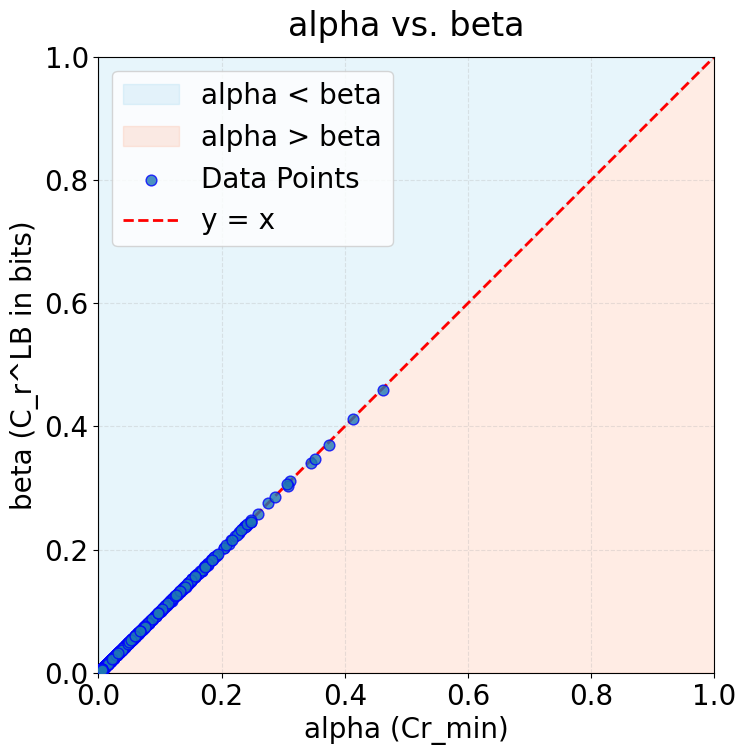

In [ ]:
if x_plot_data and y_plot_data:
        
    # --- “控制面板” ---
    plot_config = {
            'title_fontsize':   24,
            'label_fontsize':   20,
            'legend_fontsize':  20,
            'tick_fontsize':    20,
            'marker_size':         60,
            'marker_edge_width':   1.0,
            'line_width':          2.0,
            'figure_size':      (8, 8),
            'dpi':              300,
            # <<< NEW: 区域着色和文字的参数
            'region_alpha':         0.2,  # 填充区域的透明度
            'region_color_upper':  '#87CEEB', # 天蓝色 (alpha < beta)
            'region_color_lower':  '#FFA07A', # 亮珊瑚色 (alpha > beta)
            'region_text_fontsize': 16,
            'region_text_color':   '#555555' # 深灰色
        }
        # --- 结束控制面板 ---

    print("正在根据您的自定义配置生成带有区域标注的最终图像...")

    # 使用面向对象方式创建图形，便于控制图层
    fig, ax = plt.subplots(figsize=plot_config['figure_size'])
        
    # 定义x轴范围和对角线
    x_range = np.linspace(0, 1, 2)

    # <<< NEW: 填充 alpha < beta 的区域 (对角线上方)
    ax.fill_between(
            x_range, x_range, 1, 
            color=plot_config['region_color_upper'], 
            alpha=plot_config['region_alpha'],
            label='alpha < beta',
            zorder=0 # 确保在最底层
        )

    # <<< NEW: 填充 alpha > beta 的区域 (对角线下方)
    ax.fill_between(
            x_range, 0, x_range,
            color=plot_config['region_color_lower'],
            alpha=plot_config['region_alpha'],
            label='alpha > beta',
            zorder=0
        )

    # 绘制散点图
    ax.scatter(
            x_plot_data, 
            y_plot_data, 
            alpha=0.8, 
            edgecolors='b', 
            s=plot_config['marker_size'], 
            linewidths=plot_config['marker_edge_width'],
            label='Data Points',
            zorder=3 # 确保在最顶层
        )
            
    # 绘制 y=x 对角线
    ax.plot(
            x_range, x_range,
            color='red', 
            linestyle='--', 
            linewidth=plot_config['line_width'], 
            label='y = x',
            zorder=2 # 在数据点和填充区域之间
        )

    # <<< NEW: 添加文字说明
    #ax.text(0.25, 0.75, 'alpha < beta', 
    #            fontsize=plot_config['region_text_fontsize'], 
    #            color=plot_config['region_text_color'],
    #            ha='center', va='center', rotation=45, alpha=0.9, zorder=4)
        
    #ax.text(0.75, 0.25, 'alpha > beta', 
    #            fontsize=plot_config['region_text_fontsize'], 
    #            color=plot_config['region_text_color'],
    #            ha='center', va='center', rotation=45, alpha=0.9, zorder=4)

    # 设置标题和标签
    ax.set_title("alpha vs. beta", fontsize=plot_config['title_fontsize'], pad=15)
    ax.set_xlabel("alpha (Cr_min)", fontsize=plot_config['label_fontsize'])
    ax.set_ylabel("beta (C_r^LB in bits)", fontsize=plot_config['label_fontsize'])
        
    ax.tick_params(axis='both', which='major', labelsize=plot_config['tick_fontsize'])

    # 设置坐标轴范围和比例
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')

    ax.grid(True, linestyle='--', alpha=0.3, zorder=1)
            
    # 显示图例
    ax.legend(fontsize=plot_config['legend_fontsize'])
            
    # 保存图像
    plot_basename = "alpha_beta_scatter_plot_annotated"
    # 1. 保存为PNG (高分辨率光栅图，适用于网页和演示)
    plt.savefig(f"{plot_basename}.png", dpi=plot_config['dpi'], bbox_inches='tight')
        
    # 2. 保存为SVG (可缩放矢量图，适用于网页、编辑和高质量缩放)
    plt.savefig(f"{plot_basename}.svg", bbox_inches='tight')
        
    # 3. 保存为PDF (便携式文档格式，适用于报告和打印)
    plt.savefig(f"{plot_basename}.pdf", bbox_inches='tight')
            
else:
    print("没有可用于绘图的有效数据。")